In [1]:
# https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '5-flower-types-classification-dataset' dataset.
Path to dataset files: /kaggle/input/5-flower-types-classification-dataset


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


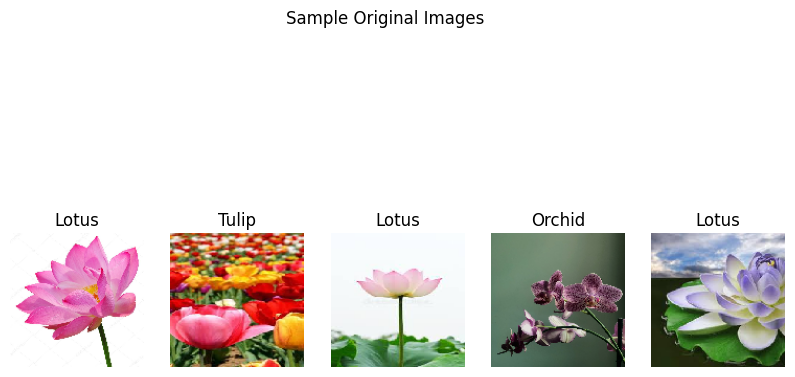

Using sample image from: /kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/8ff2e5b3dd.jpg


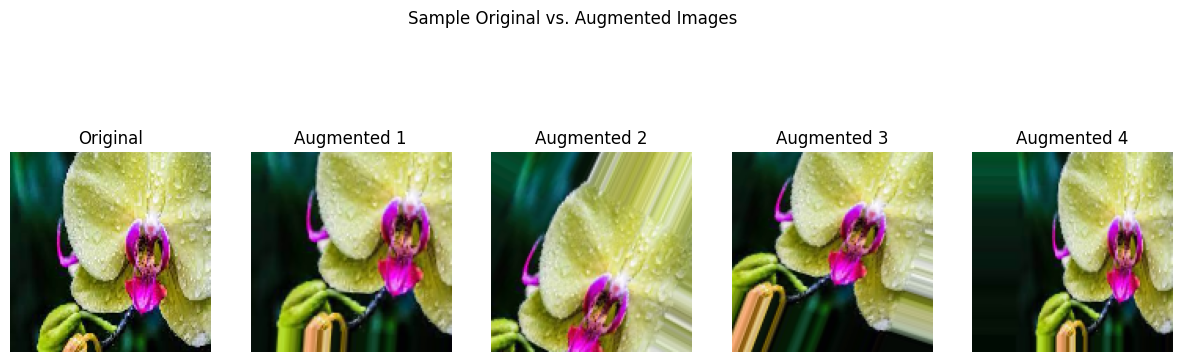


🔹 Training with config: {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.2}
Epoch 1/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 983ms/step - accuracy: 0.3843 - loss: 1.6993 - val_accuracy: 0.5480 - val_loss: 1.1557
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 956ms/step - accuracy: 0.6144 - loss: 1.0112 - val_accuracy: 0.6750 - val_loss: 0.8707
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 943ms/step - accuracy: 0.7590 - loss: 0.6525 - val_accuracy: 0.7660 - val_loss: 0.7180
Epoch 4/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 951ms/step - accuracy: 0.8569 - loss: 0.4122 - val_accuracy: 0.8010 - val_loss: 0.6640
Epoch 5/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 982ms/step - accuracy: 0.9126 - loss: 0.2661 - val_accuracy: 0.8180 - val_loss: 0.6716
Epoch 6/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 960ms/step - accuracy: 0.9468 - loss: 0.1708 - val_accuracy: 0.8200 - val_loss: 0.7358

🔹 Training with config: {'num_filters': 32, 'num_hidden': 2, 'neurons': 128, 'dropout_rate': 0.3}
Epoch 1/6
125/125

In [11]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =============================
# Step 1: Dataset paths
# =============================
base_dir = "/kaggle/input/5-flower-types-classification-dataset/flower_images"

# =============================
# Step 2: Data Generators
# =============================
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset="validation",
    shuffle=True
)

print("Classes:", list(train_gen.class_indices.keys()))

# =============================
# Step 3: Show sample dataset images
# =============================
def show_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x[i])
        plt.title(list(generator.class_indices.keys())[y[i].argmax()])
        plt.axis("off")
    plt.suptitle("Sample Original Images")
    plt.show()

show_sample_images(train_gen)

# =============================
# Step 4: Show Augmented Images with Originals
# =============================
# Use a new ImageDataGenerator for display purposes only, without normalization
# Normalizing before display is what caused the blank images.
aug_datagen_display = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to get a random image path from a directory
def get_random_image_path(base_path):
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    random_class_dir = random.choice(class_dirs)
    random_class_path = os.path.join(base_path, random_class_dir)
    images = os.listdir(random_class_path)
    random_image_name = random.choice(images)
    return os.path.join(random_class_path, random_image_name)

# Dynamically get a sample image path
sample_image_path = get_random_image_path(base_dir)
print(f"Using sample image from: {sample_image_path}")

img = load_img(sample_image_path, target_size=(128, 128))
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # Reshape to (1, 128, 128, 3)

def show_augmented_images_with_originals(img_array, datagen, num_images=4):
    plt.figure(figsize=(15, 5))

    # Display Original Image
    plt.subplot(1, num_images + 1, 1)
    # The original image is in the 0-255 range, so we normalize for plotting.
    plt.imshow(img_array.reshape(128, 128, 3) / 255.0)
    plt.title("Original")
    plt.axis("off")

    # Display Augmented Images
    i = 2
    for batch in datagen.flow(img_array, batch_size=1):
        plt.subplot(1, num_images + 1, i)
        # The augmented image is also in the 0-255 range, so we normalize it.
        # This is the key fix: ensuring all images are normalized correctly for display.
        plt.imshow(batch[0] / 255.0)
        plt.title(f"Augmented {i-1}")
        plt.axis("off")
        i += 1
        if i > num_images + 1:
            break

    plt.suptitle("Sample Original vs. Augmented Images")
    plt.show()

show_augmented_images_with_originals(x, aug_datagen_display)

# =============================
# Step 5: Model builder function
# =============================
def build_cnn_model(num_filters=32, num_hidden=1, neurons=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Conv2D(num_filters, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(num_filters*2, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    for _ in range(num_hidden):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# =============================
# Step 6: Train multiple models
# =============================
configs = [
    {"num_filters": 32, "num_hidden": 1, "neurons": 64, "dropout_rate": 0.2},
    {"num_filters": 32, "num_hidden": 2, "neurons": 128, "dropout_rate": 0.3},
    {"num_filters": 64, "num_hidden": 3, "neurons": 256, "dropout_rate": 0.5}
]

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

results = []

for cfg in configs:
    print(f"\n🔹 Training with config: {cfg}")
    model = build_cnn_model(**cfg)
    history = model.fit(
        train_gen,
        epochs=6,
        validation_data=val_gen,
        callbacks=[early_stop],
        verbose=1
    )
    val_acc = max(history.history['val_accuracy'])
    results.append((cfg, val_acc))

# =============================
# Step 7: Show Results
# =============================
print("\n📊 Final Results:")
for cfg, acc in results:
    print(f"Config {cfg} -> Best Val Accuracy: {acc:.4f}")